## Sentiment Analysis on Large Movie Review Dataset

In [1]:
import numpy as np
import pandas as pd
import os
from collections import defaultdict
import re
import matplotlib.pyplot as plt

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable as V

### Loading data and string cleaning

In [3]:
from pathlib import Path
PATH = Path("/home/ubuntu/hw2-sentiment-classification-groverpr/aclImdb")
list(PATH.iterdir())

[PosixPath('/home/ubuntu/hw2-sentiment-classification-groverpr/aclImdb/train'),
 PosixPath('/home/ubuntu/hw2-sentiment-classification-groverpr/aclImdb/README'),
 PosixPath('/home/ubuntu/hw2-sentiment-classification-groverpr/aclImdb/test'),
 PosixPath('/home/ubuntu/hw2-sentiment-classification-groverpr/aclImdb/imdbEr.txt'),
 PosixPath('/home/ubuntu/hw2-sentiment-classification-groverpr/aclImdb/imdb.vocab')]

In [4]:
def read_files(path):
    """
    Read text from all files present in path and save them in list of lists
    """
    
    all_content = []
    for file in os.listdir(path):
        with open(path/file, encoding = "ISO-8859-1") as f:
            content = list(f.readlines())
            all_content.append(content)
    return all_content

In [5]:
# this is from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
def clean_str(string):
    """Tokenization/string cleaning. """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)     
    string = re.sub(r"\'s", " \'s", string) 
    string = re.sub(r"\'ve", " \'ve", string) 
    string = re.sub(r"n\'t", " n\'t", string) 
    string = re.sub(r"\'re", " \'re", string) 
    string = re.sub(r"\'d", " \'d", string) 
    string = re.sub(r"\'ll", " \'ll", string) 
    string = re.sub(r",", " , ", string) 
    string = re.sub(r"!", " ! ", string) 
    string = re.sub(r"\(", " \( ", string) 
    string = re.sub(r"\)", " \) ", string) 
    string = re.sub(r"\?", " \? ", string) 
    string = re.sub(r"\s{2,}", " ", string)    
    return string.strip().lower()

In [6]:
def get_vocab(list_of_content):
    """Computes Dict of counts of words.
    
    Computes the number of times a word is on a document.
    """
    vocab = defaultdict(float)
    for content in list_of_content:
        for line in content:
            line = clean_str(line.strip())
            words = set(line.split())
            for word in words:
                vocab[word] += 1
    return vocab

In [7]:
pos_rev = read_files(PATH/"train/pos/")
neg_rev = read_files(PATH/"train/neg/")
pos_y = np.ones(len(pos_rev))
neg_y = np.zeros(len(neg_rev))
X = np.append(pos_rev, neg_rev)
y = np.append(pos_y, neg_y)

In [8]:
pos_y.shape, neg_y.shape, X.shape, y.shape

((12500,), (12500,), (25000,), (25000,))

In [9]:
X[:2], y[:2]

(array(["I have to say, Seventeen & Missing is much better than I expected. The perception I took from the previews was that it would be just humdrum but I was pleasantly surprised with this impressive mystery.<br /><br />Dedee Pfeiffer is Emilie, a mom who insists her daughter, Lori (Tegan Moss), not attend a so-called graduation party one weeknight, but Lori ignores her mother's wishes and takes off for the party anyway. When Lori does not come home, Emilie knows something is wrong and she begins to have visions of her daughter and the events that led to her disappearance.<br /><br />Seventeen & Missing is better than so many other TV movies of this type, as it is not so predictable. Pfeiffer is the reason to see this movie, and most of it comes off as believable. This LMN Original Movie premiered last night. 10/10",
        "I sometimes grow weary of reading reviews of some of Hitchcock's lesser known films, because almost every single one starts out with someone saying this film is

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# getting vocab from training sets
data_vocab = get_vocab([X_train])

### Initializing embedding layer with Glove embeddings

In [13]:
! head -1 /home/ubuntu/hw2-sentiment-classification-groverpr/glove.6B.50d.txt

the 0.418 0.24968 -0.41242 0.1217 0.34527 -0.044457 -0.49688 -0.17862 -0.00066023 -0.6566 0.27843 -0.14767 -0.55677 0.14658 -0.0095095 0.011658 0.10204 -0.12792 -0.8443 -0.12181 -0.016801 -0.33279 -0.1552 -0.23131 -0.19181 -1.8823 -0.76746 0.099051 -0.42125 -0.19526 4.0071 -0.18594 -0.52287 -0.31681 0.00059213 0.0074449 0.17778 -0.15897 0.012041 -0.054223 -0.29871 -0.15749 -0.34758 -0.045637 -0.44251 0.18785 0.0027849 -0.18411 -0.11514 -0.78581


We would like to initialize the embeddings from our model with the pre-trained Glove embeddings. After initializing we should "freeze" the embeddings at least initially. The rationale is that we first want the network to learn weights for the other parameters that were randomly initialize. After that phase we could finetune the embeddings to our task.

`embed.weight.requires_grad = False` freezes the embedding parameters.

The following code initializes the embedding. Here V is the vocabulary size and D is the embedding size. pretrained_weight is a numpy matrix of shape (V, D).

In [14]:
def loadGloveModel(gloveFile="/home/ubuntu/hw2-sentiment-classification-groverpr/glove.6B.100d.txt"):
    """ Loads word vectors into a dictionary."""
    f = open(gloveFile,'r')
    word_vecs = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        word_vecs[word] = np.array([float(val) for val in splitLine[1:]])
    return word_vecs

In [15]:
word_vecs = loadGloveModel()

In [16]:
print(len(word_vecs.keys()), len(data_vocab.keys()))

400000 73990


In [17]:
def delete_rare_words(word_vecs, data_vocab, min_df=2):
    """ Deletes rare words from data_vocab
    
    Deletes words from data_vocab if they are not in word_vecs
    and don't have at least min_df occurrencies in data_vocab.
    """
    words_delete = []
    for word in data_vocab:
        if data_vocab[word] < min_df and word not in word_vecs:
            words_delete.append(word)
#     print(words_delete)
    for word in words_delete: data_vocab.pop(word)
    return data_vocab

In [18]:
len(data_vocab.keys())

73990

In [19]:
# clean up issues here
data_vocab = delete_rare_words(word_vecs, data_vocab, min_df=2)

In [20]:
len(data_vocab)

59526

In [21]:
def create_embedding_matrix(word_vecs, data_vocab, min_df=2, D=100):
    """Creates embedding matrix from word vectors. """
    data_vocab = delete_rare_words(word_vecs, data_vocab, min_df)
    V = len(data_vocab.keys()) + 2
    vocab2index = {}
    W = np.zeros((V, D), dtype="float32")
    vocab = ["", "unk"]
    # adding a vector for padding
    W[0] = np.zeros(D, dtype='float32') # first vector
    # adding a vector for rare words 
    W[1] = np.random.uniform(-0.25,0.25,D) # second vector
    vocab2index["unk"] = 1
    i = 2
    for word in data_vocab:
        if word in word_vecs:
            W[i] = word_vecs[word]
            vocab2index[word] = i
            vocab.append(word)
            i += 1
        else: # words for which we couldn't find an embeddng
            W[i] = np.random.uniform(-0.25,0.25,D)
            vocab2index[word] = i
            vocab.append(word)
            i += 1   
    return W, np.array(vocab), vocab2index


In [22]:
pretrained_weight, vocab, vocab2index = create_embedding_matrix(word_vecs, data_vocab)

In [23]:
len(pretrained_weight) # note that index 0 is for padding

59528

In [24]:
D = 100
V = len(pretrained_weight)
emb = nn.Embedding(V, D)
emb.weight.data.copy_(torch.from_numpy(pretrained_weight))


 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
 0.1347  0.2155 -0.0796  ...  -0.1745  0.2082 -0.0251
-0.0394 -0.4136 -0.3717  ...   0.1673 -0.0799  0.3219
          ...             ⋱             ...          
 0.7739 -0.6130 -0.4644  ...   0.5705 -0.8239  0.3046
 0.0805 -0.4075 -0.3767  ...  -0.0297 -0.6540 -0.2768
-0.1604  0.0403 -0.7888  ...   0.0545 -0.9363 -0.9908
[torch.FloatTensor of size 59528x100]

### Encoding training and validation sets

We will be using 1D Convolutional neural networks as our model. CNNs assume a fixed input size so we need to assume a fixed size and truncate or pad the sentences as needed. Let's find a good value to set our sequence length to

In [25]:
x_len = np.array([len(x.split()) for x in X_train])

In [26]:
np.percentile(x_len, 95) # let set the max sequence len to N=40

594.0

In [27]:
X_train[0]

'Being a big fan of the "other" PLANET OF THE APES films, I rented this DVD despite my aversion to all things Tim Burton. Once again, he doesn\'t fail to disappoint with his uninspired direction. Even the ape makeup looks second rate, which is unforgivable considering the monstrous budget of this monstrosity. Mark Wahlberg proves once and for all that he is not an actor (as if BOOGIE NIGHTS wasn\'t proof enough). I was embarrassed for genuine talents such as Tim Roth and Helena Bonham Carter. No doubt their paychecks motivated them since it couldn\'t possibly have been the cliche-ridden screenplay. I rented this DVD on a special $1 night and I still feel ripped off.'

In [28]:
len(X_train[0])

670

In [29]:
# returns the index of the word or the index of "UNK" otherwise
vocab2index.get("will", vocab2index["unk"])

407

In [30]:
np.array([vocab2index.get(w, vocab2index["unk"]) for w in X_train[0].split()])

array([    1,    94,    77,    26,    15,    84,     1,     1,     1,
           1,     1,     1,     1,    54,    22,     1,    50,    48,
          53,    86,    24,    31,     1,     1,     1,     1,    23,
       27037,    78,    86,    19,    79,    34,    55,     1,     1,
          84,    75,    52,    49,    97,     1,    21,    85,    69,
          44,    84,    30,     5,    15,    22,     1,     1,     1,
          25,     7,    42,    46,    24,    71,    23,    85,    29,
          80,    17,     1,    13,     1,     1, 16942,    83,     1,
           1,    88,    39,    46,    65,     8,    95,    37,     1,
           1,    42,     1,     1,     1,     1,     3,    32,    12,
          27,    74,     6,    56, 43297,    47,    11,    38,    84,
           1,     1,     1,    54,    22,     1,    28,    94,    82,
           1,    91,    42,     1,     4,    93,    63,     1])

In [31]:
def encode_sentence(s, N=590):
    enc = np.zeros(N, dtype=np.int32)
    enc1 = np.array([vocab2index.get(w, vocab2index["unk"]) for w in s.split()])
    t = min(N, len(enc1))
    enc[:t] = enc1[:t]
    return enc

In [32]:
encode_sentence(X_train[0])

array([    1,    94,    77,    26,    15,    84,     1,     1,     1,
           1,     1,     1,     1,    54,    22,     1,    50,    48,
          53,    86,    24,    31,     1,     1,     1,     1,    23,
       27037,    78,    86,    19,    79,    34,    55,     1,     1,
          84,    75,    52,    49,    97,     1,    21,    85,    69,
          44,    84,    30,     5,    15,    22,     1,     1,     1,
          25,     7,    42,    46,    24,    71,    23,    85,    29,
          80,    17,     1,    13,     1,     1, 16942,    83,     1,
           1,    88,    39,    46,    65,     8,    95,    37,     1,
           1,    42,     1,     1,     1,     1,     3,    32,    12,
          27,    74,     6,    56, 43297,    47,    11,    38,    84,
           1,     1,     1,    54,    22,     1,    28,    94,    82,
           1,    91,    42,     1,     4,    93,    63,     1,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [33]:
x_train = np.vstack([encode_sentence(x) for x in X_train])
x_train.shape

(20000, 590)

In [34]:
x_test = np.vstack([encode_sentence(x) for x in X_test])
x_test.shape

(5000, 590)

### Playing and debugging CNN layers

In [35]:
W = len(pretrained_weight)
D = 100
N = 40

In [36]:
pretrained_weight.shape

(59528, 100)

In [37]:
emb = nn.Embedding(W, D)
emb.weight.data.copy_(torch.from_numpy(pretrained_weight))


 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
 0.1347  0.2155 -0.0796  ...  -0.1745  0.2082 -0.0251
-0.0394 -0.4136 -0.3717  ...   0.1673 -0.0799  0.3219
          ...             ⋱             ...          
 0.7739 -0.6130 -0.4644  ...   0.5705 -0.8239  0.3046
 0.0805 -0.4075 -0.3767  ...  -0.0297 -0.6540 -0.2768
-0.1604  0.0403 -0.7888  ...   0.0545 -0.9363 -0.9908
[torch.FloatTensor of size 59528x100]

In [38]:
x = x_train[:2]
x.shape

(2, 590)

In [39]:
x = torch.LongTensor(x)
x


     1     94     77  ...       0      0      0
     1    146     86  ...       0      0      0
[torch.LongTensor of size 2x590]

In [40]:
from torch.autograd import Variable as V

In [41]:
x1 = emb(V(x))
x1.shape

torch.Size([2, 590, 100])

In [42]:
x1 = x1.transpose(1,2)  # needs to convert x to (batch, embedding_dim, sentence_len)
x1.size()

torch.Size([2, 100, 590])

In [43]:
conv_3 = nn.Conv1d(in_channels=D, out_channels=50, kernel_size=3)

In [44]:
x3 = conv_3(x1)

In [45]:
x3.size()

torch.Size([2, 50, 588])

In [46]:
conv_4 = nn.Conv1d(in_channels=D, out_channels=50, kernel_size=4)
conv_5 = nn.Conv1d(in_channels=D, out_channels=50, kernel_size=5)

In [47]:
x4 = conv_4(x1)
x5 = conv_5(x1)
print(x4.size(), x5.size())

torch.Size([2, 50, 587]) torch.Size([2, 50, 586])


The convolution all apply to the same x1. How do we combine now the results of the convolutions?

In [48]:
# 100 3-gram detectors # 100 3-g 
x3 = nn.ReLU()(x3)
x3 = nn.MaxPool1d(kernel_size = 588)(x3)
x3.size()

torch.Size([2, 50, 1])

In [49]:
# 100 4-gram detectors
x4 = nn.ReLU()(x4)
x4 = nn.MaxPool1d(kernel_size = 587)(x4)
x4.size()

torch.Size([2, 50, 1])

In [50]:
# 100 5-gram detectors
x5 = nn.ReLU()(x5)
x5 = nn.MaxPool1d(kernel_size = 586)(x5)
x5.size()

torch.Size([2, 50, 1])

In [51]:
# concatenate x3, x4, x5
out = torch.cat([x3, x4, x5], 2)
out.size()

torch.Size([2, 50, 3])

In [52]:
out = out.view(out.size(0), -1)
out.size()

torch.Size([2, 150])

After this we have a fully connected network. Let's write a network that implements this.

### Dataset 

In [53]:
import torch
from torch.utils import data

class Dataset(data.Dataset):
    
    'Characterizes a dataset for PyTorch'
    def __init__(self, x, y):
        'Initialization'
        self.x = x
        self.y = y
    
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.y)
    
    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        review = self.x[index]
        sentiment = self.y[index]
        return review, sentiment

In [54]:
y_train.shape

(20000,)

In [55]:
x_train.shape

(20000, 590)

In [56]:
train_reviews = torch.LongTensor(x_train)
train_sentiment = torch.FloatTensor(y_train)

train_dataset = Dataset(train_reviews, train_sentiment)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

In [57]:
x,y=next(iter(train_loader))

In [58]:
x


     1     84   3484  ...       0      0      0
     1  14856     20  ...       0      0      0
     1      1  23693  ...       0      0      0
        ...            ⋱           ...         
     1    370   1094  ...       0      0      0
     1   1787     85  ...       0      0      0
     1    177   1495  ...       0      0      0
[torch.LongTensor of size 64x590]

In [59]:
y[:4]


 1
 0
 1
 0
[torch.DoubleTensor of size 4]

In [60]:
test_reviews = torch.LongTensor(x_test)
test_sentiment = torch.FloatTensor(y_test)

test_dataset = Dataset(test_reviews, test_sentiment)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

### 1D CNN model for sentence classification

Notation:

W -- vocabulary size
D -- embedding size
N -- MAX Sentence length

In [61]:
class SentenceCNN(nn.Module):
    
    def __init__(self, W, D, glove_weights):
        super(SentenceCNN, self).__init__()
        self.glove_weights = glove_weights
        self.embedding = nn.Embedding(W, D, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(self.glove_weights))
        self.embedding.weight.requires_grad = False ## freeze embeddings

        self.conv_3 = nn.Conv1d(in_channels=D, out_channels=50, kernel_size=3)
        self.conv_4 = nn.Conv1d(in_channels=D, out_channels=50, kernel_size=4)
        self.conv_5 = nn.Conv1d(in_channels=D, out_channels=50, kernel_size=5)
        
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(150, 1)
        
    def forward(self, x):
        x = self.embedding(x)
        x = x.transpose(1,2)
        x3 = F.relu(self.conv_3(x))
        x4 = F.relu(self.conv_4(x))
        x5 = F.relu(self.conv_5(x))
        x3 = nn.MaxPool1d(kernel_size = 588)(x3)
        x4 = nn.MaxPool1d(kernel_size = 587)(x4)
        x5 = nn.MaxPool1d(kernel_size = 586)(x5)
        out = torch.cat([x3, x4, x5], 2)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        return self.fc(out)

In [62]:
W = len(pretrained_weight)
D = 100
N = 590
model = SentenceCNN(W, D, glove_weights=pretrained_weight)

In [63]:
# testing the model
x = x_train[:10]
print(x.shape)
x = torch.LongTensor(x)

(10, 590)


In [64]:
y_hat = model(x)
y_hat.size()

torch.Size([10, 1])

### Training loops

In [65]:
model = SentenceCNN(W, D, glove_weights=pretrained_weight)

In [66]:
def train_epocs(model, epochs=10, lr=0.01, wd=0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters()) # get all parameters which need grad
    optimizer = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    
    for i in range(epochs):
        ctr = 0.
        model.train() # into training mode
        running_loss = 0.0        
        for j, data in enumerate(train_loader):
            ctr+=1
            x,y = data
            x = V(x).cuda()
            y = V(y).float().cuda()
            y_hat = model(x)
            loss = F.binary_cross_entropy_with_logits(y_hat, y.unsqueeze(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.data[0]
        print("training loss for epoch ",i+1, ": ", running_loss/ctr) # used to be loss.data[0]
        test_loss(model)

In [67]:
# defining test loss which has been used in train_epochs

def test_loss(model):
    model.eval() # go to evaluation mode
    
    running_loss = 0
    total = 0
    correct = 0
    
    for j, data in enumerate(test_loader):
        x,y = data
        x,y = V(x), V(y).float()        
        x = x.cuda() # put on gpu
        y = y.cuda()
        y_hat = model(x)
        loss_now = F.binary_cross_entropy_with_logits(y_hat, y.unsqueeze(-1))
        y_pred = y_hat > 0
        correct_now = (y_pred.float() == y.unsqueeze(-1)).sum()
        correct += correct_now.data[0]
        total += len(y.float())
        running_loss+= loss_now.data[0]
        
    accuracy = correct/total
    print("validation loss", ": ", running_loss/len(test_loader), 'Accuracy',  accuracy, '\n') # j means this many iterations till end

In [68]:
sum(y_test == 1)/len(y_test)

0.503

In [69]:
#def train(model, x_train, y_train):
model = SentenceCNN(W, D, glove_weights=pretrained_weight).cuda()

In [70]:
# initial model accuracy without training at all
test_loss(model)

validation loss :  0.6961383547963975 Accuracy 0.5026 



### LR Finder

In [71]:
len(train_loader)

313

In [72]:
len(test_loader)

79

In [73]:
def lrfinder(start, end, model, train_loader, epochs=2):
    model.train() # into training mode
    lrs = np.linspace(start, end, epochs*len(train_loader))    
    parameters = filter(lambda p: p.requires_grad, model.parameters()) # get all parameters which need grad
    optimizer = torch.optim.Adam(parameters, start)
    losses = []
    ctr = 0
    for i in range(epochs): 
        for j, data in enumerate(train_loader):
            optimizer.param_groups[0]['lr'] =lrs[ctr]
            ctr = ctr+1            
            x,y = data
            x = V(x).cuda()
            y = V(y).float().cuda()
            y_hat = model(x)
            loss = F.binary_cross_entropy_with_logits(y_hat, y.unsqueeze(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.data[0])
    plt.plot(lrs, losses)

In [74]:
model_copy = SentenceCNN(W, D, glove_weights=pretrained_weight).cuda()

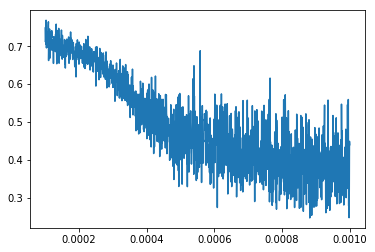

In [75]:
lrfinder(0.0001, 0.001, model_copy, train_loader, epochs=5)

In [76]:
train_epocs(model, epochs=10, lr=0.0003)

training loss for epoch  1 :  0.6507074804351733
validation loss :  0.5611682639846319 Accuracy 0.7802 

training loss for epoch  2 :  0.5202482648360462
validation loss :  0.4602180078059812 Accuracy 0.8006 

training loss for epoch  3 :  0.4569666712238385
validation loss :  0.4199211638939532 Accuracy 0.8172 

training loss for epoch  4 :  0.4248657495069047
validation loss :  0.4014192589476139 Accuracy 0.8226 

training loss for epoch  5 :  0.39974487722872165
validation loss :  0.3884179463869409 Accuracy 0.8244 

training loss for epoch  6 :  0.3806269116961537
validation loss :  0.37913551323021516 Accuracy 0.8314 

training loss for epoch  7 :  0.3672755530086188
validation loss :  0.36722659423381465 Accuracy 0.8376 

training loss for epoch  8 :  0.35427288106455207
validation loss :  0.36494443612762645 Accuracy 0.838 

training loss for epoch  9 :  0.3429942146276894
validation loss :  0.3583196910876262 Accuracy 0.8416 

training loss for epoch  10 :  0.33345241301928086


Some more training

In [77]:
train_epocs(model, epochs=5, lr=0.0003)

training loss for epoch  1 :  0.3217825372093402
validation loss :  0.3509282658371744 Accuracy 0.8472 

training loss for epoch  2 :  0.3136856664959996
validation loss :  0.35660397742368 Accuracy 0.8482 

training loss for epoch  3 :  0.30421863382045455
validation loss :  0.3460835789955115 Accuracy 0.8486 

training loss for epoch  4 :  0.2963184809532409
validation loss :  0.3500470864244654 Accuracy 0.8446 

training loss for epoch  5 :  0.28928900740969293
validation loss :  0.3445833021704155 Accuracy 0.8498 



In [78]:
train_epocs(model, epochs=5, lr=0.0003)

training loss for epoch  1 :  0.28076633720542676
validation loss :  0.3449968901238864 Accuracy 0.8508 

training loss for epoch  2 :  0.2701239127891894
validation loss :  0.34178599187090425 Accuracy 0.8506 

training loss for epoch  3 :  0.2642558252754303
validation loss :  0.34063526591922666 Accuracy 0.8506 

training loss for epoch  4 :  0.26073888517892396
validation loss :  0.33916224558142166 Accuracy 0.8514 

training loss for epoch  5 :  0.24906223969528088
validation loss :  0.34052729399143894 Accuracy 0.8508 



### Unfreezing embedding layers

In [79]:
# unfreezing the embeddings
model.embedding.weight.requires_grad = True

In [80]:
train_epocs(model, epochs=10, lr=0.0003, wd=1e-5)

training loss for epoch  1 :  0.2469370202801098
validation loss :  0.33459822607191303 Accuracy 0.8562 

training loss for epoch  2 :  0.22455412968279073
validation loss :  0.3356941104689731 Accuracy 0.8566 

training loss for epoch  3 :  0.20543431673948756
validation loss :  0.3309607817025124 Accuracy 0.8594 

training loss for epoch  4 :  0.19113999847977306
validation loss :  0.32534639669370047 Accuracy 0.8612 

training loss for epoch  5 :  0.17280511829418876
validation loss :  0.3343993966715245 Accuracy 0.8578 

training loss for epoch  6 :  0.1581073027972977
validation loss :  0.32435554416873785 Accuracy 0.8646 

training loss for epoch  7 :  0.14780488498389913
validation loss :  0.33809788294042215 Accuracy 0.857 

training loss for epoch  8 :  0.136364911608517
validation loss :  0.33202205145660835 Accuracy 0.8664 

training loss for epoch  9 :  0.12407234805032087
validation loss :  0.3400866117658494 Accuracy 0.8628 

training loss for epoch  10 :  0.1153517376524

Decreasing learning rate a little

In [81]:
train_epocs(model, epochs=5, lr=0.0001, wd=1e-4)

training loss for epoch  1 :  0.10132902566664898
validation loss :  0.3402680598105056 Accuracy 0.864 

training loss for epoch  2 :  0.10060794990712081
validation loss :  0.3385278201555904 Accuracy 0.8652 

training loss for epoch  3 :  0.10403536740964213
validation loss :  0.33704910606523103 Accuracy 0.8662 

training loss for epoch  4 :  0.09940833791185873
validation loss :  0.3367641541776778 Accuracy 0.8654 

training loss for epoch  5 :  0.09983570232225683
validation loss :  0.33482024186774145 Accuracy 0.8656 



### End